In [1]:
#from xbart import XBART
import numpy as np
import pandas as pd
import utils as ut
import pickle
import matplotlib.pyplot as plt
from improc import *
import tab_agents as tab
import model_based_agent as mba
import ensemble_mod_env as eme

In [2]:
def load_folder(fold,name,n=15):
    # Loads trajectories into a dict with lists of arrays. 
    trajs = []
    for i in range(n):
        with open(f'{fold}{name}{i}.pkl','rb') as f:
            trajs.append(pickle.load(f))
    
    t_dict = {}
    for k in trajs[0].keys():
        t_dict[k] = [np.array(trajs[i][k]).flatten() for i in range(n)]
        if k=='loc' or k=='obs':
            t_dict[k] = [t_dict[k][i].reshape(-1,2) for i in range(n)]
    return t_dict

def change_reward_ahead(df,reward_ahead,jump_limit=100):
    # Takes a dataframe where reward_ahead setting was 1.
    # Rewrites reward column using new reward_ahead
    # Returns dataframe at the end.
    start_inds = [0]
    for i in range(len(df)-1):
        if pt_dist(df['loc'][i],df['loc'][i+1]) > 10:
            start_inds.append(i+1)

    new_df = pd.DataFrame(columns=df.columns)
    for i in range(len(start_inds)-1):
        new_sec = df.iloc[start_inds[i]:start_inds[i+1]-reward_ahead].copy()
        new_r = [np.sum(dh.df['reward'][start_inds[i]+j:start_inds[i]+j+reward_ahead]) 
                     for j in range(len(new_sec))]
        new_sec['reward'] = new_r
        new_df = new_df.append(new_sec)
    return new_df,start_inds

def plot_mods(models,vmin=None,vmax=None):
    fig,ax = plt.subplots(len(models),7)
    fig.set_size_inches((15,2*len(models)))
    for m,mod in enumerate(models):
        for i,(key,item) in enumerate(mod.items()):
            if i<4:
                img = ax[m,i].imshow(item[:,:,0],vmin=-180,vmax=180)
            else:
                img = ax[m,i].imshow(item[:,:,0],vmin=vmin,vmax=vmax)
            cbar = fig.colorbar(img,ax=ax[m,i])
            ax[m,i].axis('off')
            #cbar.set_ticks([])
            if m==0:
                ax[m,i].set_title(f'{len(models)} models: {key}')
        ax[m,6].imshow(np.sign(mod['reward_on'][:,:,0]-mod['reward_off'][:,:,0]),vmin=-1,vmax=1)

In [3]:
folder = './Data/Rand09-02-12-06/'
dh = mba.DataHandler()

In [4]:
reward_ahead = 30
dh.load_df(f'{folder}df.pkl')
df_n, st_inds= change_reward_ahead(dh.df,reward_ahead)
mins = 2
pts = mins*300
dh.df = df_n
dh.params['reward_ahead']=reward_ahead

# With old smoothing

On model 0
Penalty -0.07279767717018211


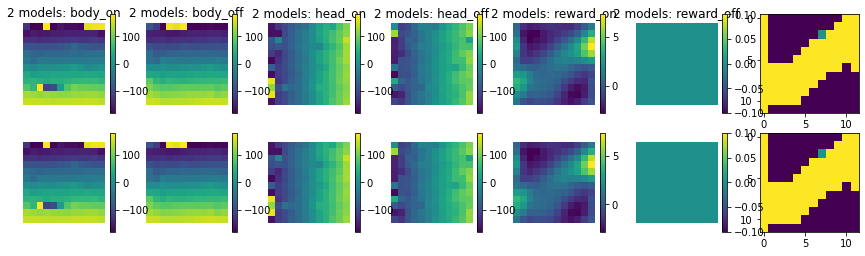

In [211]:
mod = eme.ModelSet(1,frac=1,lp_frac=.4)
mod.make_models(dh,sm_pars={'lambda':0.1,'iters':10})
pmod = mod.models[0][0]
plot_mods([pmod,pmod])

In [13]:
counts = mod.models[0][1]
counts = ut.smoothen(counts,counts,False,smooth_par=.1,iters=15)

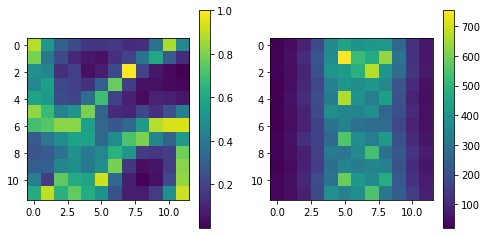

In [14]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches((8,4))
img = ax[0].imshow(np.exp(-np.abs(pmod['reward_on'][:,:,0])/np.sqrt(pmod['reward_on'][:,:,1]/counts)))
plt.colorbar(img,ax=ax[0])
img = ax[1].imshow(counts)
plt.colorbar(img,ax=ax[1])

On model 0
Penalty -0.0727976771701814


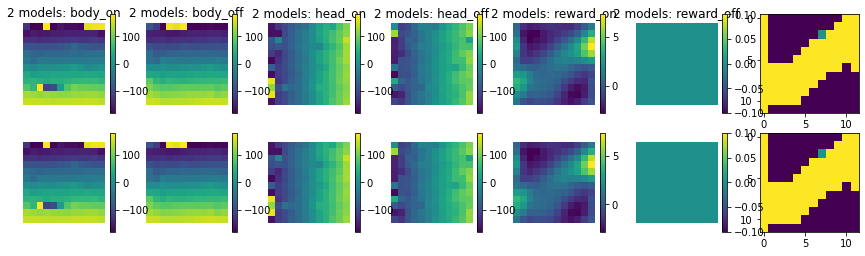

In [13]:
mod = eme.ModelSet(1,frac=1,lp_frac=.4)
mod.make_models(dh,sm_pars={'lambda':0.1,'iters':10})
pmod = mod.models[0][0]
plot_mods([pmod,pmod])

# With xbart?

In [70]:
dh.df

,t,obs_b,obs_h,prev_actions,next_obs_b,next_obs_h,reward,loc
0,0.922,30,-30,3,30,-30,19.359966,"[947.1836734693877, 900.4285714285714]"
1,1.109,30,-30,2,30,-30,19.496533,"[947.1919191919192, 899.6565656565657]"
2,1.297,30,-30,1,30,0,19.418942,"[947.2631578947369, 899.1684210526316]"
3,1.484,30,0,0,30,-30,19.542158,"[947.2783505154639, 899.0515463917526]"
4,1.672,30,-30,1,30,0,20.000526,"[947.2526315789473, 898.5052631578948]"
...,...,...,...,...,...,...,...,...
28919,294.094,30,30,3,30,30,17.033703,"[797.26, 937.43]"
28920,294.266,30,30,3,30,30,17.317475,"[797.4666666666667, 938.1809523809524]"
28921,294.454,30,30,3,30,60,16.868553,"[797.95, 939.06]"
28922,294.625,30,60,3,30,60,16.504356,"[798.25, 939.48]"


In [8]:
obs_b = dh.df['obs_b'].to_numpy().reshape((-1,1))
obs_h = dh.df['obs_h'].to_numpy().reshape((-1,1))
reward = dh.df['reward'].to_numpy()

In [9]:
test_split = 20000
x_train = (np.concatenate([obs_b,obs_h],axis=1)).astype(float)/180
reward = reward/30

x_test = x_train[test_split:,:]
y_test = reward[test_split:]
x_train = x_train[:test_split,:]
y_train = reward[:test_split]

In [113]:
xbt = XBART(num_trees = 100, num_sweeps = 40, burnin = 15, num_classes=2)
xbt.fit(x_train,y_train,p_cat=0)

XBART(num_trees = 100, num_sweeps = 40, n_min = 1, num_cutpoints = 100, alpha = 0.95, beta = 1.25, tau = 0.01, burnin = 15, mtry = 2, max_depth_num = 250, kap = 16.0, s = 4.0, verbose = False, parallel = False, seed = 0, model_num = 0, no_split_penality = 4.605170185988092, sample_weights_flag = True, num_classes = 2)

In [114]:
xbart_yhat_matrix = xbt.predict(x_train)

In [115]:
xbart_yhat_matrix.shape

(20000,)

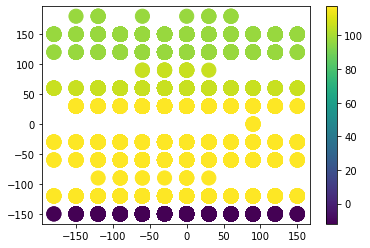

In [89]:
plt.scatter(x_train[:,1],-x_train[:,0],c=xbart_yhat_matrix,s=200)
plt.colorbar();

# Something is going wrong--not sure why it's only grouping by one dimension

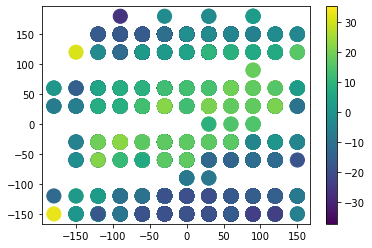

In [69]:
plt.scatter(x_test[:,1],-x_test[:,0],c=y_test,s=200)
plt.colorbar();

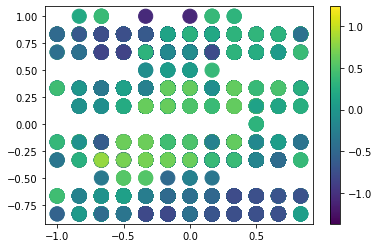

In [42]:
plt.scatter(x_train[:,1],-x_train[:,0],c=y_train,s=200)
plt.colorbar();

# This was crazy slow but it worked (tried a different package)

In [15]:
from bartpy.sklearnmodel import SklearnModel

In [18]:
model = SklearnModel()
model.fit(x_train,y_train)

SklearnModel()

In [19]:
gvec = np.linspace(-1,1,12,endpoint=False)
x_test = np.concatenate([np.tile(gvec,12).reshape(-1,1), np.repeat(gvec,12).reshape(-1,1)], 1)

In [33]:
x_test = np.zeros((144,2))

In [34]:
preds = model.predict(x_test)

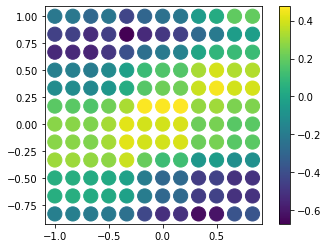

In [27]:
plt.scatter(np.repeat(gvec,12),-np.tile(gvec,12),c=preds,s=200)
plt.axis('square')
plt.colorbar();

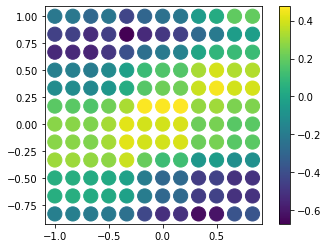

In [24]:
plt.scatter(np.repeat(gvec,12),-np.tile(gvec,12),c=preds,s=200)
plt.axis('square')
plt.colorbar();

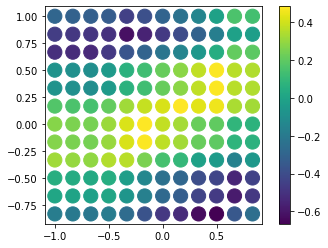

In [51]:
plt.scatter(np.repeat(gvec,12),-np.tile(gvec,12),c=preds,s=200)
plt.axis('square')
plt.colorbar();

In [68]:
npts = 2000
model = SklearnModel()
model.fit(x_train[:npts,:],y_train[:npts])
preds = model.predict(x_test)

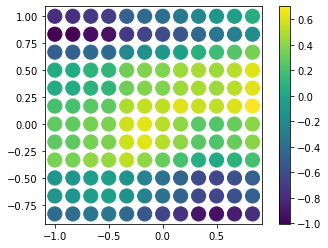

In [69]:
plt.scatter(np.repeat(gvec,12),-np.tile(gvec,12),c=preds,s=200)
plt.axis('square')
plt.colorbar();

In [61]:
npts = 300
model = SklearnModel()
model.fit(x_train[:npts,:],y_train[:npts])
preds = model.predict(x_test)

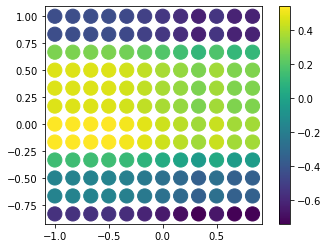

In [62]:
plt.scatter(np.repeat(gvec,12),-np.tile(gvec,12),c=preds,s=200)
plt.axis('square')
plt.colorbar();

In [63]:
npts = 600
model = SklearnModel()
model.fit(x_train[:npts,:],y_train[:npts])
preds = model.predict(x_test)

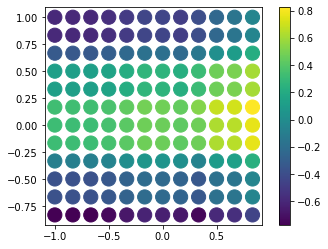

In [64]:
plt.scatter(np.repeat(gvec,12),-np.tile(gvec,12),c=preds,s=200)
plt.axis('square')
plt.colorbar();

In [65]:
npts = 1000
model = SklearnModel()
model.fit(x_train[:npts,:],y_train[:npts])
preds = model.predict(x_test)

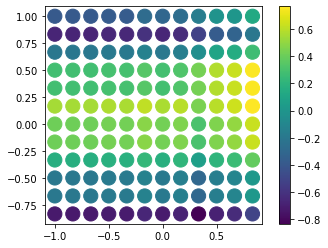

In [66]:
plt.scatter(np.repeat(gvec,12),-np.tile(gvec,12),c=preds,s=200)
plt.axis('square')
plt.colorbar();

In [22]:
with open(folder+'df.pkl','rb') as f:
    df = pickle.load(f)

In [32]:
dh.df[dh.df['prev_actions']==3]['obs_b']

0         30
6        -30
7        -30
8        -30
9        -30
        ... 
28918     30
28919     30
28920     30
28921     30
28922     30
Name: obs_b, Length: 9169, dtype: object

In [88]:
def save_df_for_r(df,fname):
    # Saves numpy arrays
    # fname has cols obs_b, obs_h, action, mean, count.
    on_view = df[df['prev_actions']==3].groupby(['obs_b','obs_h'])['reward'].agg(['mean','count'])
    off_view = df[df['prev_actions']==0].groupby(['obs_b','obs_h'])['reward'].agg(['mean','count'])
    on_view.reset_index(inplace=True)
    off_view.reset_index(inplace=True)
    
    new_df = pd.concat([on_view,off_view],ignore_index=True)
    actions = np.zeros(len(on_view)+len(off_view))
    actions[:len(on_view)] = np.ones(len(on_view))
    new_df['actions'] = actions.astype(int)
    
    new_df['obs_b'] = (new_df['obs_b']/30).astype(int) + 7
    new_df['obs_h'] = (new_df['obs_h']/30).astype(int) + 7
    
    with open(fname,'wb') as f:
        pickle.dump(new_df.to_numpy(),f)
    return new_df

def save_df_for_r_all(df,fname):
    obs_b_on = df[df['prev_actions']==3]['obs_b'].to_numpy()
    obs_b_off = df[df['prev_actions']==0]['obs_b'].to_numpy()
    obs_h_on = df[df['prev_actions']==3]['obs_h'].to_numpy()
    obs_h_off = df[df['prev_actions']==0]['obs_h'].to_numpy()
    rew_on = df[df['prev_actions']==3]['reward'].to_numpy()
    rew_off = df[df['prev_actions']==0]['reward'].to_numpy()
    
    np.concatenate([obs_b_on,obs_h_on,rew_on],axis=1)

In [3]:
new_df = save_df_for_r(dh.df,'Data/Rand09-02-12-06/arr_for_r.npy')

NameError: name 'save_df_for_r' is not defined

In [4]:
Rpy = np.load("R_for_arr.npy")

In [5]:
rpy_mu = np.std(Rpy,axis=0)

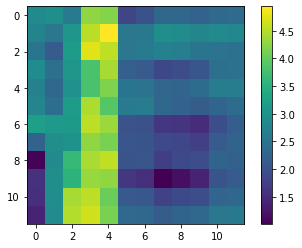

In [6]:
plt.imshow(rpy_mu.reshape((12,12)))
plt.colorbar()

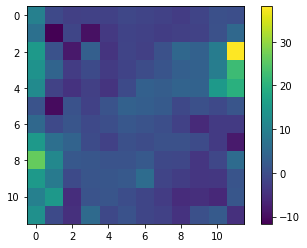

In [12]:
plt.imshow(dd['reward_on'][:,:,0])
plt.colorbar();

In [115]:
npd = new_df['mean'].to_numpy()

In [119]:
new_df

,obs_b,obs_h,mean,count,actions
0,1,2,6.057343,1,1
1,1,6,-2.649216,1,1
2,1,8,7.417078,4,1
3,1,9,9.275782,3,1
4,1,10,1.603448,3,1
...,...,...,...,...,...
207,12,8,-13.593919,399,0
208,12,9,-14.456813,100,0
209,12,10,-15.284776,60,0
210,12,11,-10.356677,52,0


In [7]:
dd, counts = ut.make_dist_dict2(dh.df)

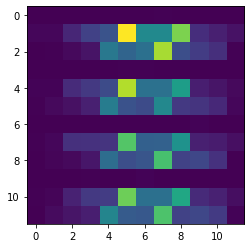

In [9]:
plt.imshow(counts)

In [15]:
dd['reward_on'][:,:,0]

array([[ 9.99464445e+00, -7.26480745e-01, -2.24198895e+00,
        -2.05407167e+00, -2.10906498e+00, -9.73768827e-01,
        -1.44248698e+00, -1.97322926e+00, -2.85243249e+00,
        -1.39346215e+00,  5.39700355e-01,  3.64198151e-01],
       [ 6.65123869e+00, -1.16431659e+01, -1.18890017e+00,
        -9.40283470e+00, -3.44018244e+00, -1.72907520e+00,
        -2.10822959e+00, -2.53756210e+00, -2.16611048e+00,
        -1.89625362e+00,  6.68219741e-01,  5.20507477e+00],
       [ 1.52380933e+01,  9.74732057e-01, -8.28581424e+00,
         3.41244506e+00, -4.18804162e+00, -1.41272270e+00,
        -2.22611820e+00,  6.20622003e-01,  4.97749858e+00,
         3.79023209e+00,  9.24830332e+00,  3.80883091e+01],
       [ 1.36987919e+01,  4.29582181e+00, -2.76929912e+00,
        -5.21442745e-01, -2.95263070e+00, -1.63964499e+00,
        -5.98978445e-02,  1.19624419e+00,  3.44564536e+00,
         3.74950651e+00,  9.34172573e+00,  2.24749876e+01],
       [ 1.21594904e+01, -1.78605849e+00, -4.3179049

# Test BART in R with all data to check for expressiveness.

In [105]:
np.save(folder+'alldatR.npy', alls, allow_pickle=True)

In [159]:
alls_c = alls[:1000,:]

In [160]:
df = pd.DataFrame(alls_c.astype(float))

In [161]:
df = df.iloc[:,:3].groupby([0,1]).agg(['mean','count'])

In [162]:
df = df.reset_index()
df.columns = ['a','b','mean','count']

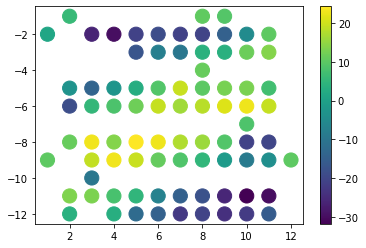

In [163]:
plt.scatter(df['b'],-df['a'],c=df['mean'].to_numpy(),s=200)
plt.colorbar();

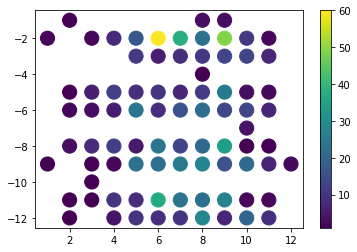

In [164]:
plt.scatter(df['b'],-df['a'],c=df['count'].to_numpy(),s=200)
plt.colorbar();

In [165]:
p1k = np.load('1kpts.npy',allow_pickle=True)

In [178]:
p1k = p1k[:,::2]

In [179]:
p1k.shape

(800, 144)

In [180]:
pmu = np.mean(p1k,axis=0)
pstd = np.std(p1k,axis=0)

In [184]:
obs_b = np.repeat(range(12),12)
obs_h = np.tile(range(12),12)

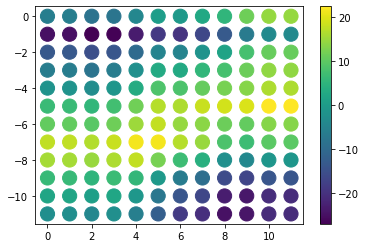

In [189]:
plt.scatter(obs_h,-obs_b,c=pmu,s=200)
plt.colorbar();

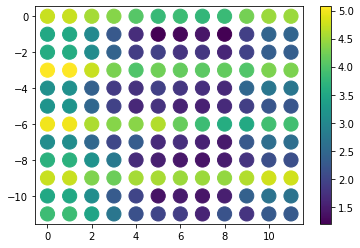

In [188]:
plt.scatter(obs_h,-obs_b,c=pstd,s=200)
plt.colorbar();

In [190]:
p_diff = np.load('rcheckdiff.npy',allow_pickle=True)
preds = np.load('rcheckpreds.npy',allow_pickle=True)

In [191]:
preds.shape

(800, 288)

In [192]:
p_diff.shape

(800, 144)

In [230]:
pred_mu = np.mean(p_diff,axis=0)
pred_std = np.std(p_diff,axis=0)

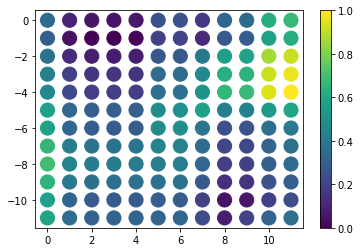

In [217]:
plt.scatter(obs_h,-obs_b,c=pred_mu_norm,s=200)
plt.colorbar();

In [216]:
pred_mu_norm = normit(pred_mu)

In [215]:
def normit(arr):
    # Scales linearly to be btwn 0 and 1
    return (arr-np.min(arr))/(np.max(arr)-np.min(arr))

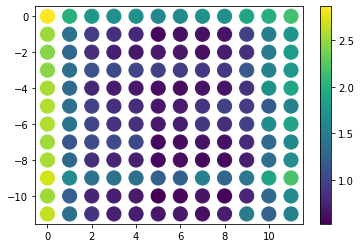

In [198]:
plt.scatter(obs_h,-obs_b,c=pred_std,s=200)
plt.colorbar();

In [218]:
sm_mu = pmod['reward_on'][:,:,0]
sm_std = pmod['reward_on'][:,:,1]
sm_mu_norm = normit(sm_mu)


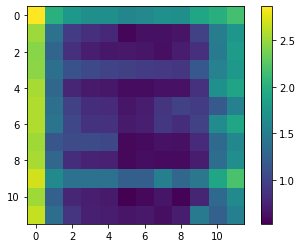

In [228]:
plt.imshow(pred_std.reshape(12,12))
plt.colorbar();
# Std for 800 draws after bart with all data

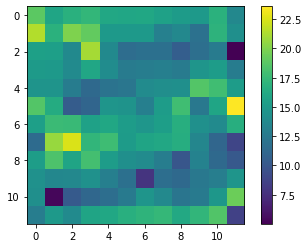

In [226]:
plt.imshow(np.sqrt(sm_std))
plt.colorbar()
# Std for smoothing method (real data)

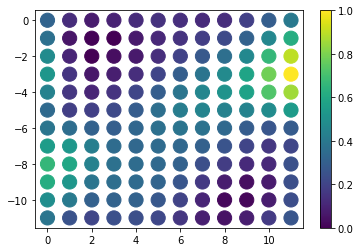

In [220]:
plt.scatter(obs_h,-obs_b,c=sm_mu_norm,s=200)
plt.colorbar();

In [ ]:
fig,ax = plt.subplots(2,2)
fig.set_size_inches((10,5))
ax[0].imshow(pred_mu_norm.reshape(12,12))
ax[1].imshow(pred)

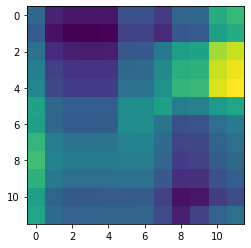

In [223]:
plt.imshow(pred_mu_norm.reshape(12,12))

In [16]:
p_diff = np.load('rcheckdiff200.npy',allow_pickle=True)
preds = np.load('rcheckpreds200.npy',allow_pickle=True)

In [17]:
pred_mu = np.mean(p_diff,axis=0)
pred_std = np.std(p_diff,axis=0)

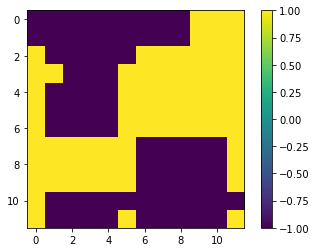

In [29]:
plt.imshow(np.sign(pred_mu.reshape(12,12)+.1))
plt.colorbar();

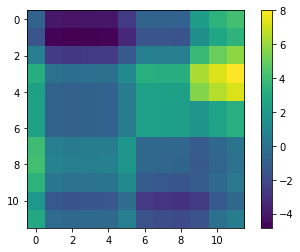

In [27]:
plt.imshow(pred_mu.reshape(12,12))
plt.colorbar();

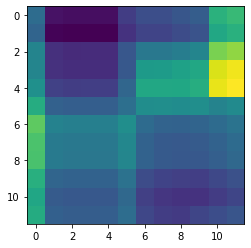

In [234]:
plt.imshow(pred_mu.reshape(12,12))

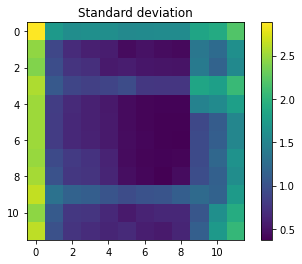

In [22]:
plt.imshow(pred_std.reshape(12,12))
plt.colorbar();
plt.title('Standard deviation');

# Trying UAML

In [19]:
### broken library; examples don't work either

In [5]:
from sklearn.svm import SVC
from uaml.classifier import UAClassifier

In [7]:
df = dh.df
ang2r = lambda x: x/30+7

obs_b_on = ang2r(df[df['prev_actions']==3]['obs_b'].to_numpy())
obs_b_off = ang2r(df[df['prev_actions']==0]['obs_b'].to_numpy())
obs_h_on = ang2r(df[df['prev_actions']==3]['obs_h'].to_numpy())
obs_h_off = ang2r(df[df['prev_actions']==0]['obs_h'].to_numpy())
rew_on = df[df['prev_actions']==3]['reward'].to_numpy()
rew_off = df[df['prev_actions']==0]['reward'].to_numpy()

ons = [obs_b_on,obs_h_on,rew_on]
offs = [obs_b_off,obs_h_off,rew_off]

ons = [np.expand_dims(on,1) for on in ons]
offs = [np.expand_dims(off,1) for off in offs]
ons = np.concatenate(ons,axis=1)
offs = np.concatenate(offs,axis=1)

alls = np.concatenate([ons,offs],axis=0)
acts = np.zeros((alls.shape[0],1))
acts[:ons.shape[0]] += 1
alls = np.concatenate([alls,acts],axis=1)
alls = alls.astype(float)

In [8]:
alls

array([[ 8.        ,  6.        , 19.35996564,  1.        ],
       [ 6.        , 10.        , 20.50126236,  1.        ],
       [ 6.        , 10.        , 20.68118008,  1.        ],
       ...,
       [ 8.        ,  6.        , 16.80961221,  0.        ],
       [ 8.        ,  6.        , 17.2791473 ,  0.        ],
       [ 8.        ,  6.        , 16.91666667,  0.        ]])

In [12]:
num_train = 10000
x_train = alls[:num_train,[0,1,3]]
y_train = np.sign(alls[:num_train,2])
x_test = alls[num_train:,[0,1,3]]
y_test = np.sign(alls[num_train:,2])

In [13]:
# Use SVC as base (probabilistic) estimator
estm = SVC(gamma=2, C=1, probability=True) 

# Constuct and fit an uncertainty-aware classifier with 500 estimators and parallelize over 5 cores 
clf = UAClassifier(estm, mc_sample_size=0.5, n_mc_samples=10, n_jobs=2)
clf.fit(x_train, y_train)

# # Obtain predictions by means of majority voting and calculate aleatoric and epistemic uncertainty
# yhat = clf.predict(X_test, avg=True)
# ua, ue = clf.get_uncertainty(X_test)

UAClassifier(estimator=SVC(C=1, gamma=2, probability=True), mc_sample_size=0.5,
             n_jobs=2)

# Trying MLE of Q(s,a=1)-Q(s,a=0) > 0

In [24]:
from scipy.stats import norm

In [30]:
# from cdf of normal distribution, p = 1-cdf()
# t dist for small samples sizes at first? # no, bart samples are bigger
def POver0(mu,sig):
    # Returns the probability that the RV is above 0
     return 1-norm.cdf(-mu/sig)
def entropy(probs):
    return -probs*np.log(probs)-(1-probs)*np.log(1-probs)

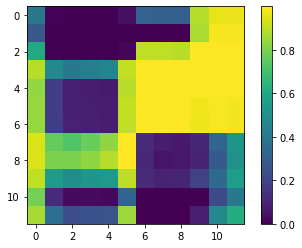

In [38]:
plt.imshow(POver0(pred_mu,pred_std).reshape(12,12))
plt.colorbar();

In [43]:
probs = POver0(pred_mu,pred_std)

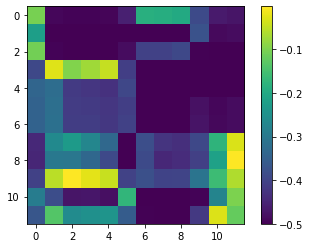

In [45]:
plt.imshow(-np.abs(probs-.5).reshape(12,12))
plt.colorbar();

# Results from SoftBART

In [14]:
sb = np.load('softbart.npy',allow_pickle=True)

In [15]:
sb_diff = sb[:,1::2] - sb[:,::2]
sb_mu = np.mean(sb_diff,axis=0).reshape(12,12)
sb_std = np.std(sb_diff,axis=0).reshape(12,12)

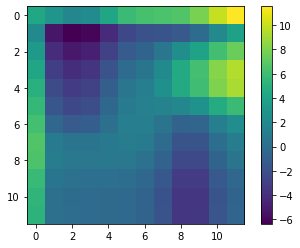

In [20]:
plt.imshow(sb_mu)
plt.colorbar()

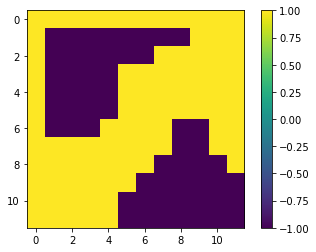

In [22]:
plt.imshow(np.sign(sb_mu+.2))
plt.colorbar()

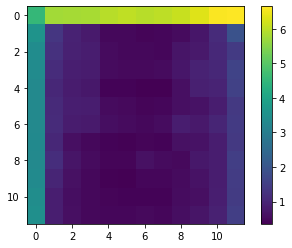

In [18]:
plt.imshow(sb_std)
plt.colorbar();

In [26]:
probs = POver0(sb_mu,sb_std)

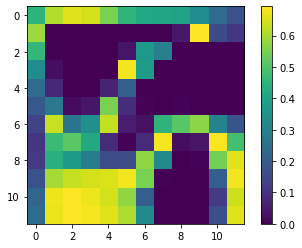

In [31]:
plt.imshow(entropy(probs).reshape(12,12))
plt.colorbar();